Notebook to accompany article by Arseniev-Koehler and Foster, "Machine learning as a model for cultural learning: teaching an algorithm what it means to be fat." All code last checked on Python 3 in Windows 11/27/2019. Please cite our paper or [GitHub repo](https://github.com/arsena-k/Word2Vec-bias-extraction) if reused. 

# Measuring Connotations in Word Embedding Models

This research explores how language around body weight in the news is loaded with meanings of gender, morality, healthiness, and socio-economic status (SES). For example, is "obese" more masculine or feminine? What about "slender"? To do so, this notebook uses two geometric approaches and a machine-learning approach (SVM classifier). 

In [22]:
#load up libraries (you may need to install some of these, with conda install or pip install, if not already installed)
from gensim.models import Word2Vec, KeyedVectors
from itertools import combinations
from numpy import mean, std, equal
from sklearn.metrics.pairwise import cosine_similarity
from seaborn import stripplot
import matplotlib.pyplot as plt
from pylab import rcParams
from pylab import xlim

In [23]:
#download these from our github repo, and keep in your working directory (same folder as this jupyter notebook)
import build_lexicon 
import word_lists 
import dimension
import semantic_svm
#if you don't have a standard Python library that these depend on you may need to install those too with conda install or pip install

**Load in a pretrained Word2Vec Model**

*Option 1:* Use the Word2Vec model that we used in our paper, and trained on New York Times articles on body weight and health. 
Please see our paper for training details. 
* Download our model, called 'modelA_ALLYEARS_500dim_10CW' from our [OSF](https://osf.io/jvarx/files/), and put it in your working directory. Your working directory is the folder where this Jupyter notebook is currently saved. 

In [30]:
#    An example for a PC computer if your model is in your downloads folder, and you're using a model named "modelA_ALLYEARS_500dim_10CW" 
#currentmodel=  Word2Vec.load("C:/Users/Alina Arseniev/Downloads/modelA_ALLYEARS_500dim_10CW")

#   An example for a Mac if your model is in your downloads folder, and you're using a model named "modelA_ALLYEARS_500dim_10CW" 
#currentmodel=  Word2Vec.load("~/Downloads/modelA_ALLYEARS_500dim_10CW")

#   An example based on my set-up of folders:
currentmodel=  Word2Vec.load("C:/Users/Alina Arseniev/Dropbox/GSRM/LexisNexis Data/Word2VecModels/modelA_ALLYEARS_500dim_10CW") #load up a trained Word2Vec model. You'll need to tailor this path to your computer

In [8]:
#Get the vocab size and word count of words in model:

wordcounts= 0
for word, vocab_obj in currentmodel.wv.vocab.items():
    wordcounts+= vocab_obj.count   
#vocab size of 81250 words, and total of 92785779 tokens

*Option 2:* Use a pretrained Word2Vec Model from Google, trained on Google News
* Download a pre-trained model on GoogleNews, described on this [site](https://code.google.com/archive/p/word2vec/) and [download the model here](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing).
* Extract the downloaded files, and make sure you have the file called "GoogleNews-vectors-negative300.bin.gz" in your working directory. Your working directory is the folder where this Jupyter notebook is currently saved. 
* Some of the vocabulary words used in this notebook may not exist in the Google News model, since the vocabulary words used in this paper were selected based on a Word2Vec model trained on the New York Times. 

In [24]:
#   An example for a PC computer if your model is in your downloads folder, and you're using the Google model 
#currentmodel=  KeyedVectors.load_word2vec_format('C:/Users/Alina Arseniev/Downloads/GoogleNews-vectors-negative300.bin.gz', limit=500000, binary=True)

#   An example for a Mac if your model is in your downloads folder, and you're using the Google model 
#currentmodel=  KeyedVectors.load_word2vec_format("~/Downloads/GoogleNews-vectors-negative300.bin.gz",limit=500000, binary=True)

#   An example based on my set-up of folders:
currentmodel= KeyedVectors.load_word2vec_format('D:/PreTrained_W2V_Models/GoogleNews-vectors-negative300.bin.gz', limit=500000, binary=True)  

**For all methods to extract semantic dimensions, we need some anchor words (e.g, "woman" vs "man" to extract a dimension for gender)**

Import anchor words for four semantic dimensions, and then clean these up to only include the ones that are actually part of the vocabulary of the embedding model that is currently loaded into Python. 

* For morality, we use lexicon from the Moral Foundations Theory, which breaks down morality into 5 dimensions. We focus on the Purity dimension, which is most relevant to moralization of obesity. As a validation check, we can also use all words from all dimensions (called, mfdwords). 
* As a validation check for gender, we can also use anchor words proposed by Bolukbasi and colleagues (genderboluk)
* See our paper for additional details on lexicon development. 



In [31]:
genderwords= build_lexicon.dimension_lexicon_builtin('gender', currentmodel) 
healthwords= build_lexicon.dimension_lexicon_builtin('health', currentmodel) 
seswords= build_lexicon.dimension_lexicon_builtin('ses', currentmodel) 
puritywords= build_lexicon.dimension_lexicon_builtin('purity', currentmodel, min_count=50)  #this is our measure of morality (the Purity dimension in Moral Foundations Theory)

#for validation
mfdwords= build_lexicon.dimension_lexicon_builtin('moral_mfd', currentmodel, min_count=50) #this is to validate our word list for morality, using all Moral Foundations Theory words for morality
genderbolukwords= build_lexicon.dimension_lexicon_builtin('genderboluk', currentmodel) #this is to validate our word list for gender, using only Bolukbasi words for gender

## Geometric Approaches to Measure Connotations

Use two geometric approaches to extract a semantic direction (gender, morality, health or socio-economic status (SES)). Then then identify how a word-vector loads onto this dimension (e.g., does "overweight" connote femininity or masculinity?) 

Our primary method we refer to in the code as the Larsen method, since it was inspired by [Larsen et. al. 2016](https://arxiv.org/abs/1512.09300?context=cs). This method averages pairwise differences between anchor words (e.g., woman-man). See our paper for details. We also use the Bolukbasi method, inspired by [Bolukbasi et. al. 2016](https://arxiv.org/abs/1607.06520). See our paper for details on these methods. 

* The Bolukbasi Method requires an even number of words; the purity and moral words are NOT even, as they come from an established lexicon (Moral Foundations Theory), and thus cannot be used with the Bolukbasi method as is. 

In [32]:
#instantiate each dimension with the class "dimension" and set the the method to 'larsen' or to 'bolukbasi'
gender= dimension.dimension(genderwords, method='larsen') 
health= dimension.dimension(healthwords,'larsen') 
ses= dimension.dimension(seswords,'larsen') 

#The Bolukbasi Method requires an even number of words that are intentionally paired- our morality words (purity and moralmfd) are not set up this way, and thus cannot be used with the Bolukbasi method as is. 
purity= dimension.dimension(puritywords,'larsen') #specifically the words representing "purity" in moral foundations theory


#for validation:
moralmfd = dimension.dimension(mfdwords,'larsen') 
genderboluk= dimension.dimension(genderbolukwords, method='larsen')  

**Training and testing accuracy**

In [33]:
#compute training and testing accuracy for each dimension
for i in [gender, health, ses, purity]:
    print('\033[1m' + i.semantic_direction.direction_of_interest + '\033[0m' + " method:" + str(i.method) ,
          "\n \t Train Accuracy: " + str(round(i.trainaccuracy()[0],2)) , "Test Accuracy: " + str(round(i.testaccuracy()[0],2)), '\n'
            "\t Correct/Total Train N:", str(sum(equal(i.trainaccuracy()[1],i.trainaccuracy()[2]))) + "/" + str(len(i.trainaccuracy()[2])) , '\n'
            "\t Correct/Total Test N:", str(sum(equal(i.testaccuracy()[1],i.testaccuracy()[2]))) +  "/" + str(len(i.testaccuracy()[2])) , '\n' )

gender method:larsen 
 	 Train Accuracy: 0.92 Test Accuracy: 0.95 
	 Correct/Total Train N: 109/118 
	 Correct/Total Test N: 57/60 

health method:larsen 
 	 Train Accuracy: 0.93 Test Accuracy: 0.92 
	 Correct/Total Train N: 121/130 
	 Correct/Total Test N: 55/60 

ses method:larsen 
 	 Train Accuracy: 0.95 Test Accuracy: 0.98 
	 Correct/Total Train N: 95/100 
	 Correct/Total Test N: 59/60 

purity method:larsen 
 	 Train Accuracy: 0.94 Test Accuracy: 0.97 
	 Correct/Total Train N: 60/64 
	 Correct/Total Test N: 29/30 



In [31]:
#Function to visualize testing accuracy:
def acc_plot(testing_dimension, dimension_lexicon):
    rcParams['figure.figsize'] = 9,9
    
    myplot= stripplot(testing_dimension.testaccuracy()[3], dimension_lexicon.pos_test + dimension_lexicon.neg_test , testing_dimension.testaccuracy()[1], size=10)
    L= plt.legend(loc="upper left", bbox_to_anchor=[0, 1],
               ncol=2, shadow=True, title="True Class", fancybox=True)
    plt.ylabel("Testing Words")
    plt.xlabel("Cosine similarity to dimension, possible range -1 (" + dimension_lexicon.neg_label + ") to +1 (" + dimension_lexicon.pos_label + ")" )
    L.get_texts()[0].set_text(dimension_lexicon.neg_label)
    L.get_texts()[1].set_text(dimension_lexicon.pos_label)
    
    plt.axvline(x=0, color='red', linestyle='dashed')
    plt.title("Cosine similarity between testing words and "+ str(testing_dimension.semantic_direction.direction_of_interest) + " dimension" )
    myplot.grid(b=True, linestyle='dashed')
    plt.show()

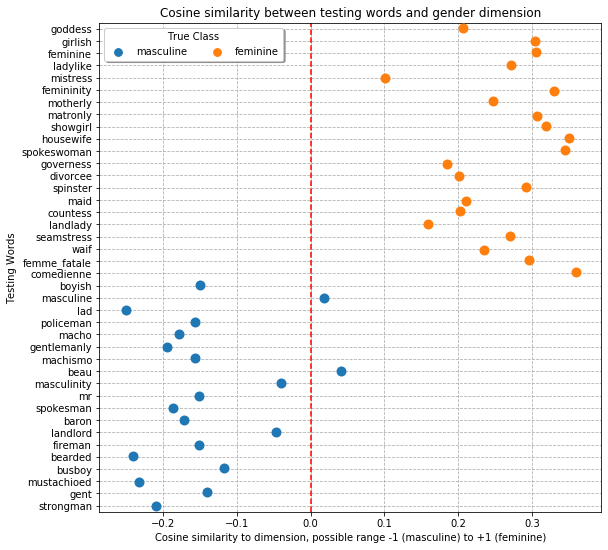

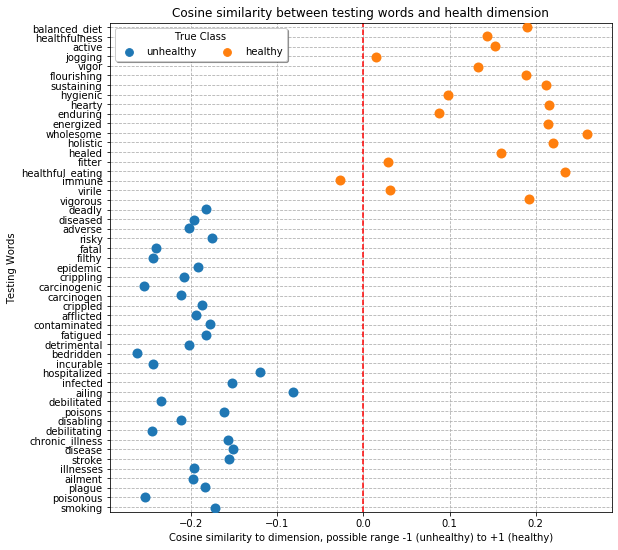

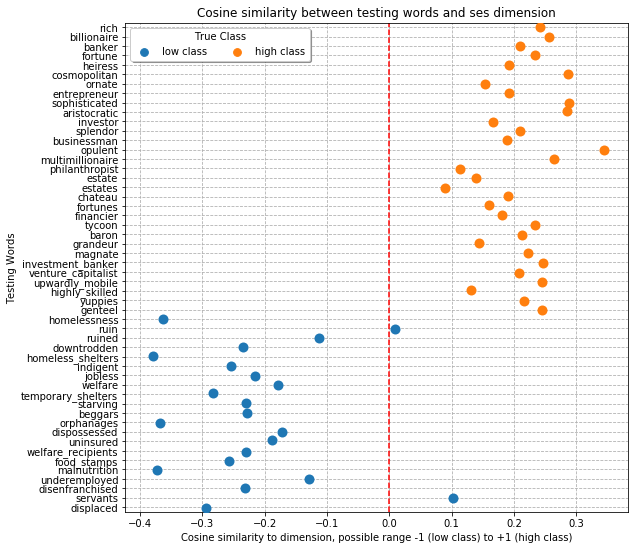

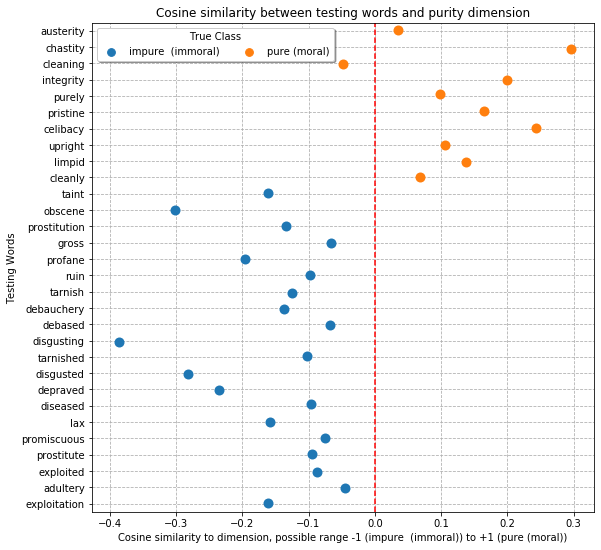

In [32]:
#Do visualization
acc_plot(gender, genderwords) #change this to a dimension lexicon and corresponding set of words
acc_plot(health, healthwords) 
acc_plot(ses, seswords) 
acc_plot(purity, puritywords) 

**Visualize predicted meanings of obesity lexicon**

In [28]:
#Function to visualize meanings of obesity lexicon:
def obesity_plot(obesity_dimension, dimension_lexicon): #change this to a dimension lexicon and corresponding set of words):
    rcParams['figure.figsize'] = 7, 7
    myplot= stripplot( obesity_dimension.cos_sim_bodyterms()[1], obesity_dimension.cos_sim_bodyterms()[0], color= 'blue', size=12) #change dimension here
    plt.axvline(x=0, color='red', linestyle='dashed')
    plt.ylabel("Obesity words")
    plt.title("Cosine similarity between obesity words and "+ str(obesity_dimension.semantic_direction.direction_of_interest) + " dimension" )
    plt.xlabel("Cosine similarity to dimension, possible range -1 (" + dimension_lexicon.neg_label + ") to +1 (" + dimension_lexicon.pos_label + ")" )
    myplot.grid(b=True, linestyle='dashed')
    plt.show()

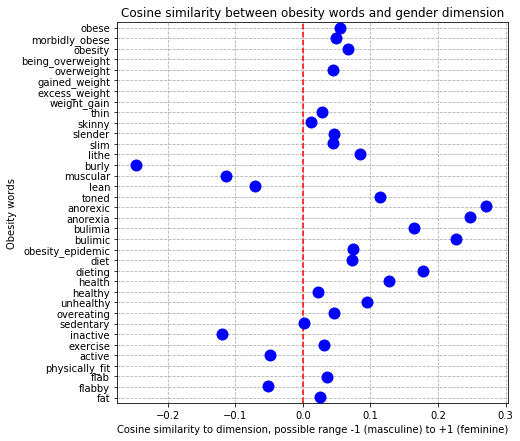

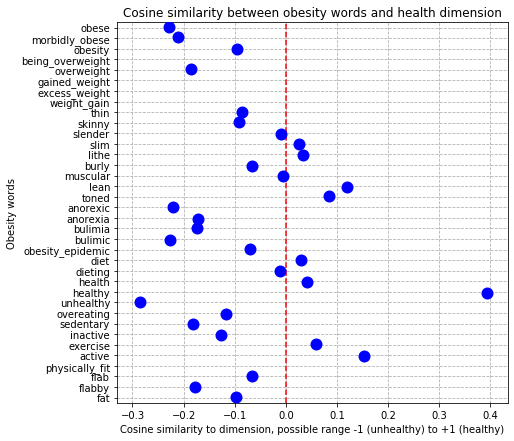

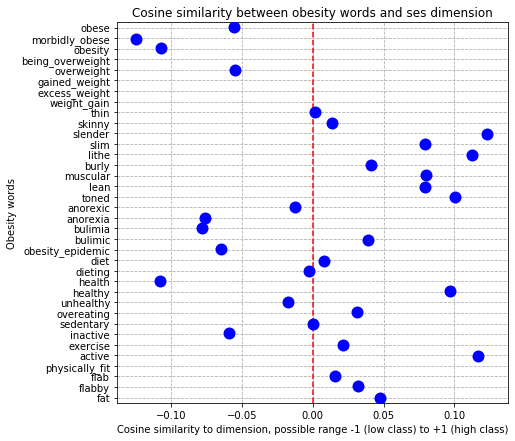

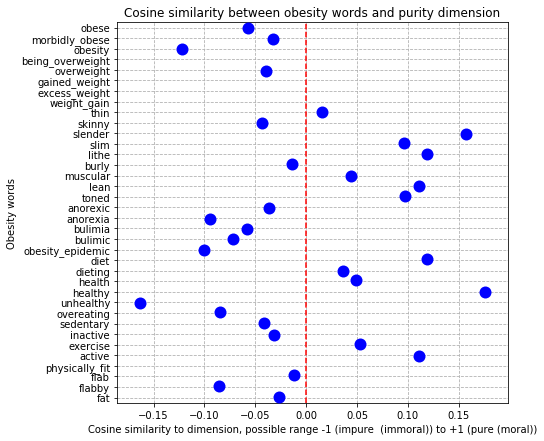

In [29]:
#Do visualization
obesity_plot(gender, genderwords)
obesity_plot(health, healthwords) #note that a few words (e.g, "healthy", "unhealthy") are are in the obesity lexicon and used as an anchor word for health here are also in the scale. In the paper, we exclude these from obesity lexicon when reporting results about health.
obesity_plot(ses, seswords)
obesity_plot(purity, puritywords)

### Additional Robustness Checks for Geometric Approaches

**1. How sensitive are these methods to word-choice? How generalizable are they beyond training words?**

To test this, we can create the dimension on all but one held-out pair of anchor words, and then test 1) if the training accuracy is still high and 2) how well the held-out words are classified ('test' accuracy). We do this across all pairs of anchor words, and look at the the mean accuracies, below.

In [180]:
dimension.kfold_dim(genderwords) #input here is the vocabulary object with cleaned up word lists, can change to look at various dimensions. Automatically set for larsen method.

dimension.kfold_dim(healthwords) 

dimension.kfold_dim(seswords) 

dimension.kfold_dim(puritywords) 

Train Accuracy:0.9245283018867925 Test Accuracy:0.8333333333333334
Train Accuracy:0.9339622641509434 Test Accuracy:0.75
Train Accuracy:0.9150943396226415 Test Accuracy:0.8333333333333334
Train Accuracy:0.9150943396226415 Test Accuracy:1.0
Train Accuracy:0.9245283018867925 Test Accuracy:0.75
Train Accuracy:0.9245283018867925 Test Accuracy:0.9166666666666666
Train Accuracy:0.9339622641509434 Test Accuracy:0.9166666666666666
Train Accuracy:0.9056603773584906 Test Accuracy:1.0
Train Accuracy:0.9339622641509434 Test Accuracy:0.9166666666666666
Train Accuracy:0.9351851851851852 Test Accuracy:1.0
With default 10 splits, each training subset size: 54 Each hold-out subset size: 5
Mean, SD, Min Accuracy across Training Subsets: 0.92 0.01 0.91
Mean, SD, Min Accuracy across Held-Out Subsets: 0.89 0.1 0.75
Train Accuracy:0.9224137931034483 Test Accuracy:0.9285714285714286
Train Accuracy:0.9396551724137931 Test Accuracy:0.8571428571428571
Train Accuracy:0.9482758620689655 Test Accuracy:0.78571428571

**2. How similar are the semantic directions to each other?**

We extract the dimensions, and then compute cosine similarity between them. 

In [6]:
for i,j in combinations([gender, purity, health, ses], 2):
    print("Cosine similarity between", i.semantic_direction.direction_of_interest, "and", j.semantic_direction.direction_of_interest, 
          "is:", cosine_similarity(i.dimensionvec().reshape(1,-1),j.dimensionvec().reshape(1,-1) )[0][0])

Cosine similarity between gender and purity is: 0.1284663
Cosine similarity between gender and health is: 0.13262549
Cosine similarity between gender and ses is: -0.042516768
Cosine similarity between purity and health is: 0.5468799
Cosine similarity between purity and ses is: 0.29842997
Cosine similarity between health and ses is: 0.26261476


**3. Do both Larsen and Bolukbasi geometric approaches recover the same vector for a given semantic relationship?**

Extract a dimension using the Larsen approach, and then using the Bolukbasi approach, and then compute cosine similarity between the two vectors. 

In [109]:
print("Cosine Similarity between dimensions extracted using Larsen and Bolukbasi approaches for...")
for i in [genderwords, genderbolukwords, healthwords, seswords]: #this doesn't work for purity and moralmfd, which aren't paired
    lars= dimension.dimension(i, method='larsen')
    bol= dimension.dimension(i, method='bolukbasi') 
    print(str(lars.semantic_direction.direction_of_interest), ":",
            cosine_similarity(lars.dimensionvec().reshape(1,-1),bol.dimensionvec().reshape(1,-1) )[0][0])     

Cosine Similarity between dimensions extracted using Larsen and Bolukbasi approaches for...
gender : 0.9779756
genderboluk : 0.9890837
health : 0.94981253
ses : 0.9706726


**4. How different are these dimensions from all words in the corpus?**

In [65]:
#This may be slow on a model that is larger (i.e., more vocabulary words or higher dimensionality) than ours, consider limiting vocabulary size

print("Mean and SD of cosine similarities between a given dimension and all other words in the model vocabulary:")
for i in [gender, genderboluk, health, ses, purity, moralmfd]:
    cossim_container= []
    for j in currentmodel.wv.vectors:
        cossim_container.append(cosine_similarity(i.dimensionvec().reshape(1,-1), j.reshape(1,-1))[0][0])
    print(i.semantic_direction.direction_of_interest, "Mean:",  mean(cossim_container), "SD:", std(cossim_container))                           

Mean and SD of Cosine Similarity between each dimension and all other words in vocabulary:
gender Mean: -0.0021336377 SD: 0.09457286
genderboluk Mean: 0.0025354347 SD: 0.08238872
health Mean: -0.026776453 SD: 0.1007121
ses Mean: 0.0037677824 SD: 0.09711154
purity Mean: -0.006143091 SD: 0.098541304
moral_mfd Mean: -0.016751815 SD: 0.10745869


## Linear Classifier Approaches to Measure Connotations

Train a linear classifier (Suppor Vector Machine) to learn to discriminate between key terms at one end of a dimension and the other. 

* Since word-vectors usually are 100-500 dimensions, and there are few example keyterms in our lexicon, this method easily overfits to the anchor words used to trained the classifier. We use a slightly lower dimensional Word2Vec model (300-D) and advise that specific results from this method are interpreted with caution.

In [4]:
#   An example loading in a 300-D Word2Vec model based on my set-up of folders:
currentmodel=  Word2Vec.load("C:/Users/Alina Arseniev/Dropbox/GSRM/LexisNexis Data/Word2VecModels/modelA_ALLYEARS_300dim_10CW") #load up a trained Word2Vec model. You'll need to tailor this path to your computer

In [36]:
#Clean lexicon for this word2vec model
gender3words= build_lexicon.dimension_lexicon_builtin('gender3', currentmodel)  #as described in our paper, our gender training words seem to be "too easy" and overfit, gender2 and gender3 includes fewer easy words (e.g, removing "she" and "he") and more stereotypes
healthwords= build_lexicon.dimension_lexicon_builtin('health', currentmodel) 
seswords= build_lexicon.dimension_lexicon_builtin('ses', currentmodel) 
puritywords= build_lexicon.dimension_lexicon_builtin('purity', currentmodel, min_count=50)  

#train model to classify lexicon for each dimension
gender3_svm = semantic_svm.semantic_svm(gender3words)
purity_svm= semantic_svm.semantic_svm(puritywords) #purity only has around 60 total examples to learn from, not many! 
health_svm = semantic_svm.semantic_svm(healthwords)
ses_svm = semantic_svm.semantic_svm(seswords)

Warning, SVM Classifier may overfit with few training words
Warning, SVM Classifier may overfit with few training words
Warning, SVM Classifier may overfit with few training words


In [37]:
#testing/training accuracy
for i in [gender3_svm, purity_svm, health_svm, ses_svm]:
    print('For ' + str(i.semantic_direction.direction_of_interest) + ": ", '\n'
        "Train accuracy (N, %): "  + str(i.trainaccuracy()[1])+ ', ' + str(round(i.trainaccuracy()[0], 2)) , '\n'
        "Test accuracy (N, %): " + str(i.testaccuracy()[1]) +', ' + str(round(i.testaccuracy()[0], 2)))
          
#"/"+ str(round(i.testaccuracy()[0], 2)) ) #+ " (" + str( round( np.std(i),2) )+ ")" )

For gender:  
Train accuracy (N, %): 108, 1.0 
Test accuracy (N, %): 40, 1.0
For gender3:  
Train accuracy (N, %): 152, 1.0 
Test accuracy (N, %): 40, 1.0
For purity:  
Train accuracy (N, %): 64, 1.0 
Test accuracy (N, %): 29, 0.97
For health:  
Train accuracy (N, %): 92, 1.0 
Test accuracy (N, %): 50, 0.98
For ses:  
Train accuracy (N, %): 80, 1.0 
Test accuracy (N, %): 51, 0.98


In [38]:
#Function for visualization
def obesity_plot_svm(obesity_dimension):
    rcParams['figure.figsize'] = 7, 7
    myplot= stripplot( obesity_dimension.pred_bodyterms()[1], obesity_dimension.pred_bodyterms()[0], color= 'blue', size=12) #change dimension here
    plt.ylabel("Obesity words")
    plt.title("Predicted meaning obesity words for " + obesity_dimension.semantic_direction.direction_of_interest + " using a support vector machine")
    plt.xlabel("Predicted class of word with respect to dimension, either 0 (" + obesity_dimension.semantic_direction.neg_label + ") or 1 (" + obesity_dimension.semantic_direction.pos_label + ")" )
    myplot.grid(b=True, linestyle='dashed')
    plt.show()

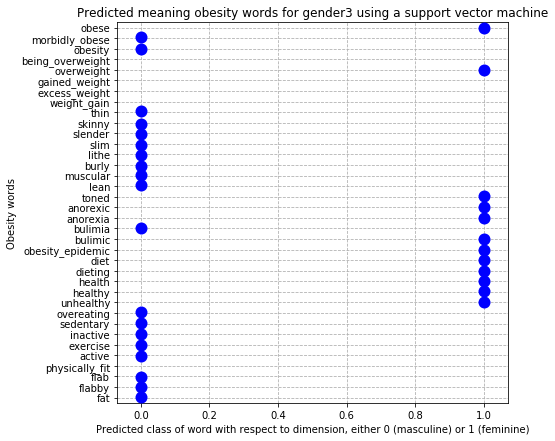

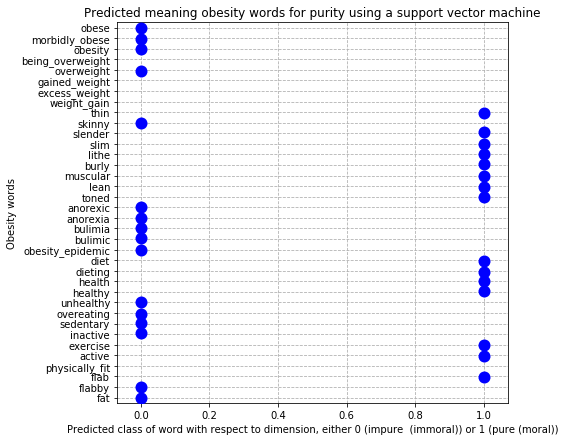

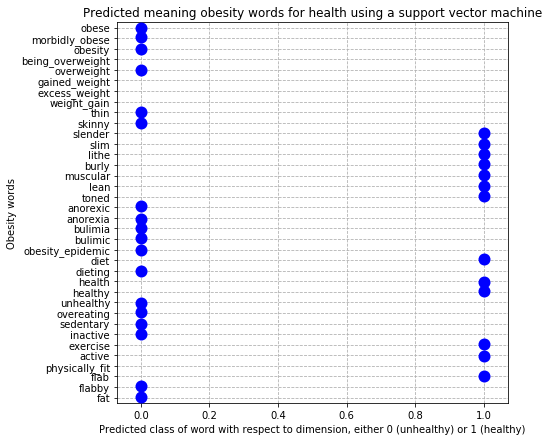

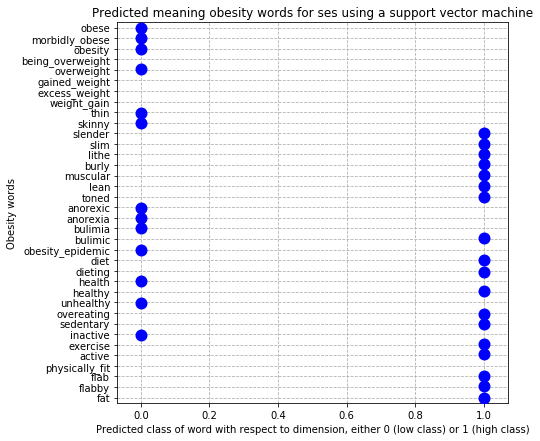

In [39]:
#Do visualization
obesity_plot_svm(gender3_svm)
obesity_plot_svm(purity_svm)
obesity_plot_svm(health_svm)
obesity_plot_svm(ses_svm)